# GBDT para detecção de anomalias

O GBDT é mais indicado para dados tabulares estruturados, oferecendo alta precisão e interpretabilidade, mas exige labels e pode ser mais custoso. O Isolation Forest é simples, rápido e não supervisionado, funcionando bem em grandes volumes de dados, embora seja limitado em capturar relações complexas. Já os Autoencoders se destacam em dados de alta dimensão e não estruturados, como imagens ou séries temporais, conseguindo modelar padrões complexos, mas com menor interpretabilidade e maior custo computacional.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pre processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# classifiers
from catboost import CatBoostClassifier, Pool
# from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep
# from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
import tensorflow as tf

# valuation
from sklearn.metrics import classification_report

# seed para reprodução dos resultados
RANDOM = 42

2025-09-26 11:30:46.867560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758886246.903078     398 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758886246.912038     398 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_train = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv")
df_test = pd.read_csv("/kaggle/input/fraud-detection/fraudTest.csv")

In [3]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
df_train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

## Pré-processamento

In [6]:
# remove colunas que não serão utilizadas
columns_to_drop = ['Unnamed: 0', 'trans_num', 'first', 'last', 'gender', 'city_pop', \
                    'zip', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'job', 'lat', 'long']

df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)

In [7]:
df_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,0


In [8]:
# procura linhas com valores nulos ou infinitos
def filter_null_inf(df): 
    df.isna().sum()
    df[df.isin([float("inf"), float("-inf")]).any(axis=1)]
    
    # remove valores infinitos e não numericos
    df = df.replace([float("inf"), float("-inf")], pd.NA)
    df = df.dropna()

    return df

df_train = filter_null_inf(df_train)
df_test = filter_null_inf(df_test)

In [9]:
# convertendo data e horário em atributos numéricos
def convert_date(df):
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"], format='%Y-%m-%d %H:%M:%S')
    df["year"] = df["trans_date_trans_time"].dt.year
    df["month"] = df["trans_date_trans_time"].dt.month
    df["day"] = df["trans_date_trans_time"].dt.day
    df["hour"] = df["trans_date_trans_time"].dt.hour
    df["minute"] = df["trans_date_trans_time"].dt.minute
    df["second"] = df["trans_date_trans_time"].dt.second
    
    # remove a feature original
    df = df.drop(columns=["trans_date_trans_time"])
    return df

df_train = convert_date(df_train)
df_test = convert_date(df_test)

In [10]:
# checa resultado após pré-processamento
df_train.head()

,cc_num,merchant,category,amt,street,city,state,is_fraud,year,month,day,hour,minute,second
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,0,2019,1,1,0,0,18
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,0,2019,1,1,0,0,44
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,0,2019,1,1,0,0,51
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,0,2019,1,1,0,1,16
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,0,2019,1,1,0,3,6


In [11]:
df_train["is_fraud"].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [12]:
# define features categoricas e numericas
CATEGORICAL_FEATURES = ['merchant', 'category', 'street', 'city', 'state']
NUMERIC_FEATURES = ['cc_num', 'amt', 'year', 'month', 'day', 'hour', 'minute', 'second']
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES
TARGET_FEATURE = 'is_fraud'

## EDA

[]

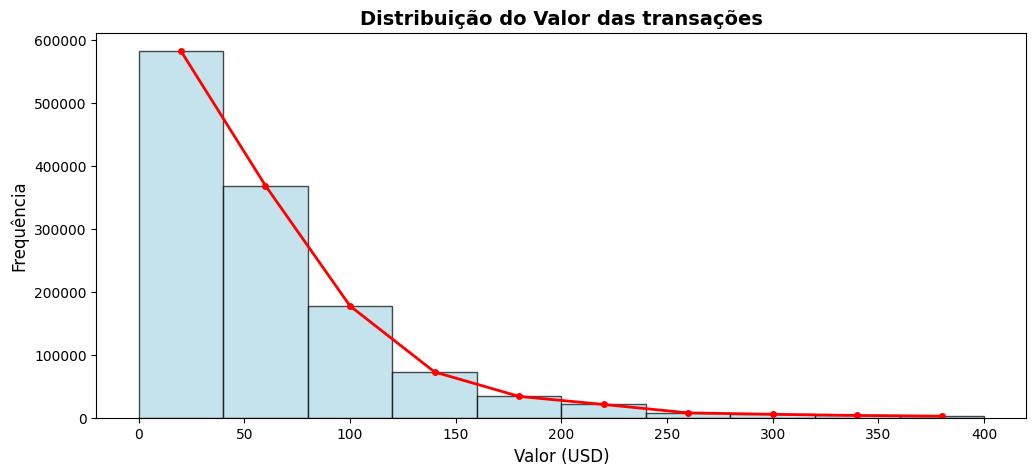

In [13]:
plt.figure(figsize=(12, 5))

# histograma com linha de frequência
counts, bins, patches = plt.hist(df_train['amt'],color='lightblue', edgecolor='black', range=(0, 400), alpha=0.7)

# adicionar linha conectando os pontos médios dos bins
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, counts, color='red', linewidth=2, marker='o', markersize=4)
plt.title('Distribuição do Valor das transações', fontsize=14, fontweight='bold')
plt.xlabel('Valor (USD)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.plot()

### Data Split

In [14]:
X_train, y_train = df_train.drop(columns=["is_fraud"]), df_train["is_fraud"]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=RANDOM)
X_test, y_test = df_test.drop(columns=["is_fraud"]), df_test["is_fraud"] 

In [15]:
# transforma a variavel target em numerica 
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

## Gradient Boosted Decision Tree

Para fins de comparação, escolhi o `catboost` como classificador pois ele conta com diversas vantagens relevantes para o problema específico:

- Suporte nativo a variáveis categóricas.
- hiperparâmetros padrão competitivos contra modelos ajustados de XGBoost/LightGBM.
- Robustez contra overfitting, principalmente em datasets menores

ref.: https://catboost.ai/docs/en/

In [16]:
clf = CatBoostClassifier(
    iterations=120,
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
    eval_metric='Logloss',
    task_type="GPU",
    random_seed=RANDOM
)

clf.fit(X_train, y_train, 
        cat_features=CATEGORICAL_FEATURES, 
        eval_set=(X_val, y_val),
        use_best_model=True
)

print('CatBoost model parameters:')
print(clf.get_params())

0:	learn: 0.5997548	test: 0.5997477	best: 0.5997477 (0)	total: 29.1ms	remaining: 3.46s
1:	learn: 0.5231228	test: 0.5231100	best: 0.5231100 (1)	total: 41.6ms	remaining: 2.45s
2:	learn: 0.4593798	test: 0.4593644	best: 0.4593644 (2)	total: 53.9ms	remaining: 2.1s
3:	learn: 0.4053773	test: 0.4053555	best: 0.4053555 (3)	total: 66.1ms	remaining: 1.92s
4:	learn: 0.3592698	test: 0.3592428	best: 0.3592428 (4)	total: 78.2ms	remaining: 1.8s
5:	learn: 0.3197037	test: 0.3196737	best: 0.3196737 (5)	total: 90.4ms	remaining: 1.72s
6:	learn: 0.2852852	test: 0.2852482	best: 0.2852482 (6)	total: 103ms	remaining: 1.66s
7:	learn: 0.2552900	test: 0.2552460	best: 0.2552460 (7)	total: 114ms	remaining: 1.6s
8:	learn: 0.2291279	test: 0.2290874	best: 0.2290874 (8)	total: 126ms	remaining: 1.56s
9:	learn: 0.2061704	test: 0.2061278	best: 0.2061278 (9)	total: 138ms	remaining: 1.52s
10:	learn: 0.1851633	test: 0.1851019	best: 0.1851019 (10)	total: 150ms	remaining: 1.49s
11:	learn: 0.1667160	test: 0.1666455	best: 0.1666

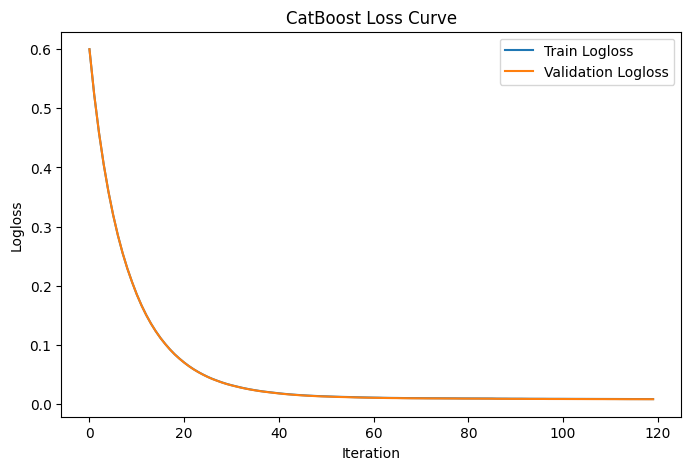

In [17]:
# pega a loss de training e validation por interacao
train_log = clf.get_evals_result()['learn']['Logloss']
val_log = clf.get_evals_result()['validation']['Logloss']

plt.figure(figsize=(8,5))
plt.plot(train_log, label='Train Logloss')
plt.plot(val_log, label='Validation Logloss')
plt.xlabel("Iteration")
plt.ylabel("Logloss")
plt.title("CatBoost Loss Curve")
plt.legend()
plt.show()

In [18]:
# testando
y_pred = clf.predict(X_test)

print("Report:\n", classification_report(y_test, y_pred))

Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.86      0.63      0.73      2145

    accuracy                           1.00    555719
   macro avg       0.93      0.81      0.86    555719
weighted avg       1.00      1.00      1.00    555719

